In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
multi_year_pollutant = pd.read_csv("./Multiyear_pm25_empirical.csv",index_col = None)

In [3]:
isrm_multiyear_ejscreen = pd.read_csv("isrm_multiyear_ejscreen.csv",index_col = 0)

In [4]:
isrm_bg_crosswalk = pd.read_csv("isrm_bg_crosswalk.csv",index_col = 0).rename(columns = {"isrm_grid_cell_num":"isrm","bg_ID":"fips"})

In [5]:
multiyear_pollutant_merge = multi_year_pollutant.merge(isrm_bg_crosswalk,how  = "left")

In [6]:
multiyear_pollutant_merge["pred_wght_pop"] = multiyear_pollutant_merge["pred_wght"]*multiyear_pollutant_merge["population"]

In [7]:
mulityear_isrm_prediction = multiyear_pollutant_merge.groupby(["year","isrm"]).agg({"pred_wght_pop":"sum","population":"sum"}).reset_index()

In [8]:
mulityear_isrm_prediction["pred_wght"] = mulityear_isrm_prediction["pred_wght_pop"]/mulityear_isrm_prediction["population"]

In [9]:
mulityear_isrm_prediction_merge = mulityear_isrm_prediction.merge(isrm_multiyear_ejscreen,how = "left")

In [10]:
isrm_justice40_crosswalk=pd.read_csv("isrm_justice40_crosswalk_v1.csv",index_col = 0)

In [11]:
J40_isrm = isrm_justice40_crosswalk[isrm_justice40_crosswalk["flag_j40_v1_land"]==True]

In [12]:
mulityear_isrm_prediction_merge["J40"] = np.where(mulityear_isrm_prediction_merge.isrm.isin(J40_isrm.isrm.to_list()),mulityear_isrm_prediction_merge["Population"],0)
mulityear_isrm_prediction_merge["non_J40"] = mulityear_isrm_prediction_merge["Population"]-mulityear_isrm_prediction_merge["J40"]

mulityear_isrm_prediction_merge["Poverty"] = mulityear_isrm_prediction_merge.Population*mulityear_isrm_prediction_merge.LOWINCPCT
mulityear_isrm_prediction_merge["non_Poverty"] = mulityear_isrm_prediction_merge.Population - mulityear_isrm_prediction_merge["Poverty"]

mulityear_isrm_prediction_merge["POC"] = mulityear_isrm_prediction_merge["Population"]-mulityear_isrm_prediction_merge["White"]

In [13]:
pm25_multiyear_j40_sum = pd.DataFrame({"year":range(1999,2015)})

for group in ["Population","Black","White","Hispanic","Asian","POC","J40","non_J40","Poverty","non_Poverty"]:
    mulityear_isrm_prediction_merge["pred_"+group] = mulityear_isrm_prediction_merge["pred_wght"]*mulityear_isrm_prediction_merge[group]
    g = mulityear_isrm_prediction_merge.groupby(["year"])
    pm25_multiyear_j40_sum[group] = (g["pred_"+group].sum()/g[group].sum()).to_list()



In [14]:
pm25_multiyear_j40_sum["disparity"] = pm25_multiyear_j40_sum[["Black","Asian","Hispanic","White"]].max(axis = 1)-pm25_multiyear_j40_sum["Population"]
pm25_multiyear_j40_sum["disparity_j40"] = pm25_multiyear_j40_sum["J40"]-pm25_multiyear_j40_sum["Population"]
pm25_multiyear_j40_sum["disparity_POC"] = pm25_multiyear_j40_sum["POC"]-pm25_multiyear_j40_sum["Population"]
pm25_multiyear_j40_sum["disparity_lowinc"] = pm25_multiyear_j40_sum["Poverty"]-pm25_multiyear_j40_sum["Population"]


In [15]:
for group in ["Population","Black","White","Asian","Hispanic","POC","J40","non_J40","Poverty","non_Poverty"]:
    vars()["yearly_change_pm25_"+group] = (pm25_multiyear_j40_sum[group][1]-pm25_multiyear_j40_sum[group][15])/14
    vars()["yearly_relative_change_pm25_"+group] = np.mean([(pm25_multiyear_j40_sum[group][:15].to_list())[i]/(pm25_multiyear_j40_sum[group][1:].to_list())[i]-1 for i in range(1,15)])

In [16]:
year = pm25_multiyear_j40_sum["year"].to_list()
for group in ["Population","Black","White","Asian","Hispanic","POC","J40","non_J40","Poverty","non_Poverty"]:
    vars()["pm25_forecast_"+group] = pm25_multiyear_j40_sum[group].to_list()
    vars()["pm25_relative_forecast_"+group] = pm25_multiyear_j40_sum[group].to_list()
for i in range(15, 35):
    year.append(year[i]+1)
    for group in ["Population","Black","White","Asian","Hispanic","POC","J40","non_J40","Poverty","non_Poverty"]:
        vars()["pm25_forecast_"+group].append(vars()["pm25_forecast_"+group][i]-vars()["yearly_change_pm25_"+group])
        
        vars()["pm25_relative_forecast_"+group].append(vars()["pm25_relative_forecast_"+group][i]*(1-vars()["yearly_relative_change_pm25_"+group]))        


In [17]:
test_list = [year]
test_relative_list = [year]
for group in ["Population","Black","White","Asian","Hispanic","POC","J40","non_J40","Poverty","non_Poverty"]:
    test_list.append(vars()["pm25_forecast_"+group])
    test_relative_list.append(vars()["pm25_relative_forecast_"+group])
    
pred_pm25_forecast = pd.DataFrame(test_list,index = ["year","Population","Black","White","Asian","Hispanic","POC","J40","non_J40","Poverty","non_Poverty"]).T
pred_relative_pm25_forecast = pd.DataFrame(test_relative_list,index = ["year","Population","Black","White","Asian","Hispanic","POC","J40","non_J40","Poverty","non_Poverty"]).T

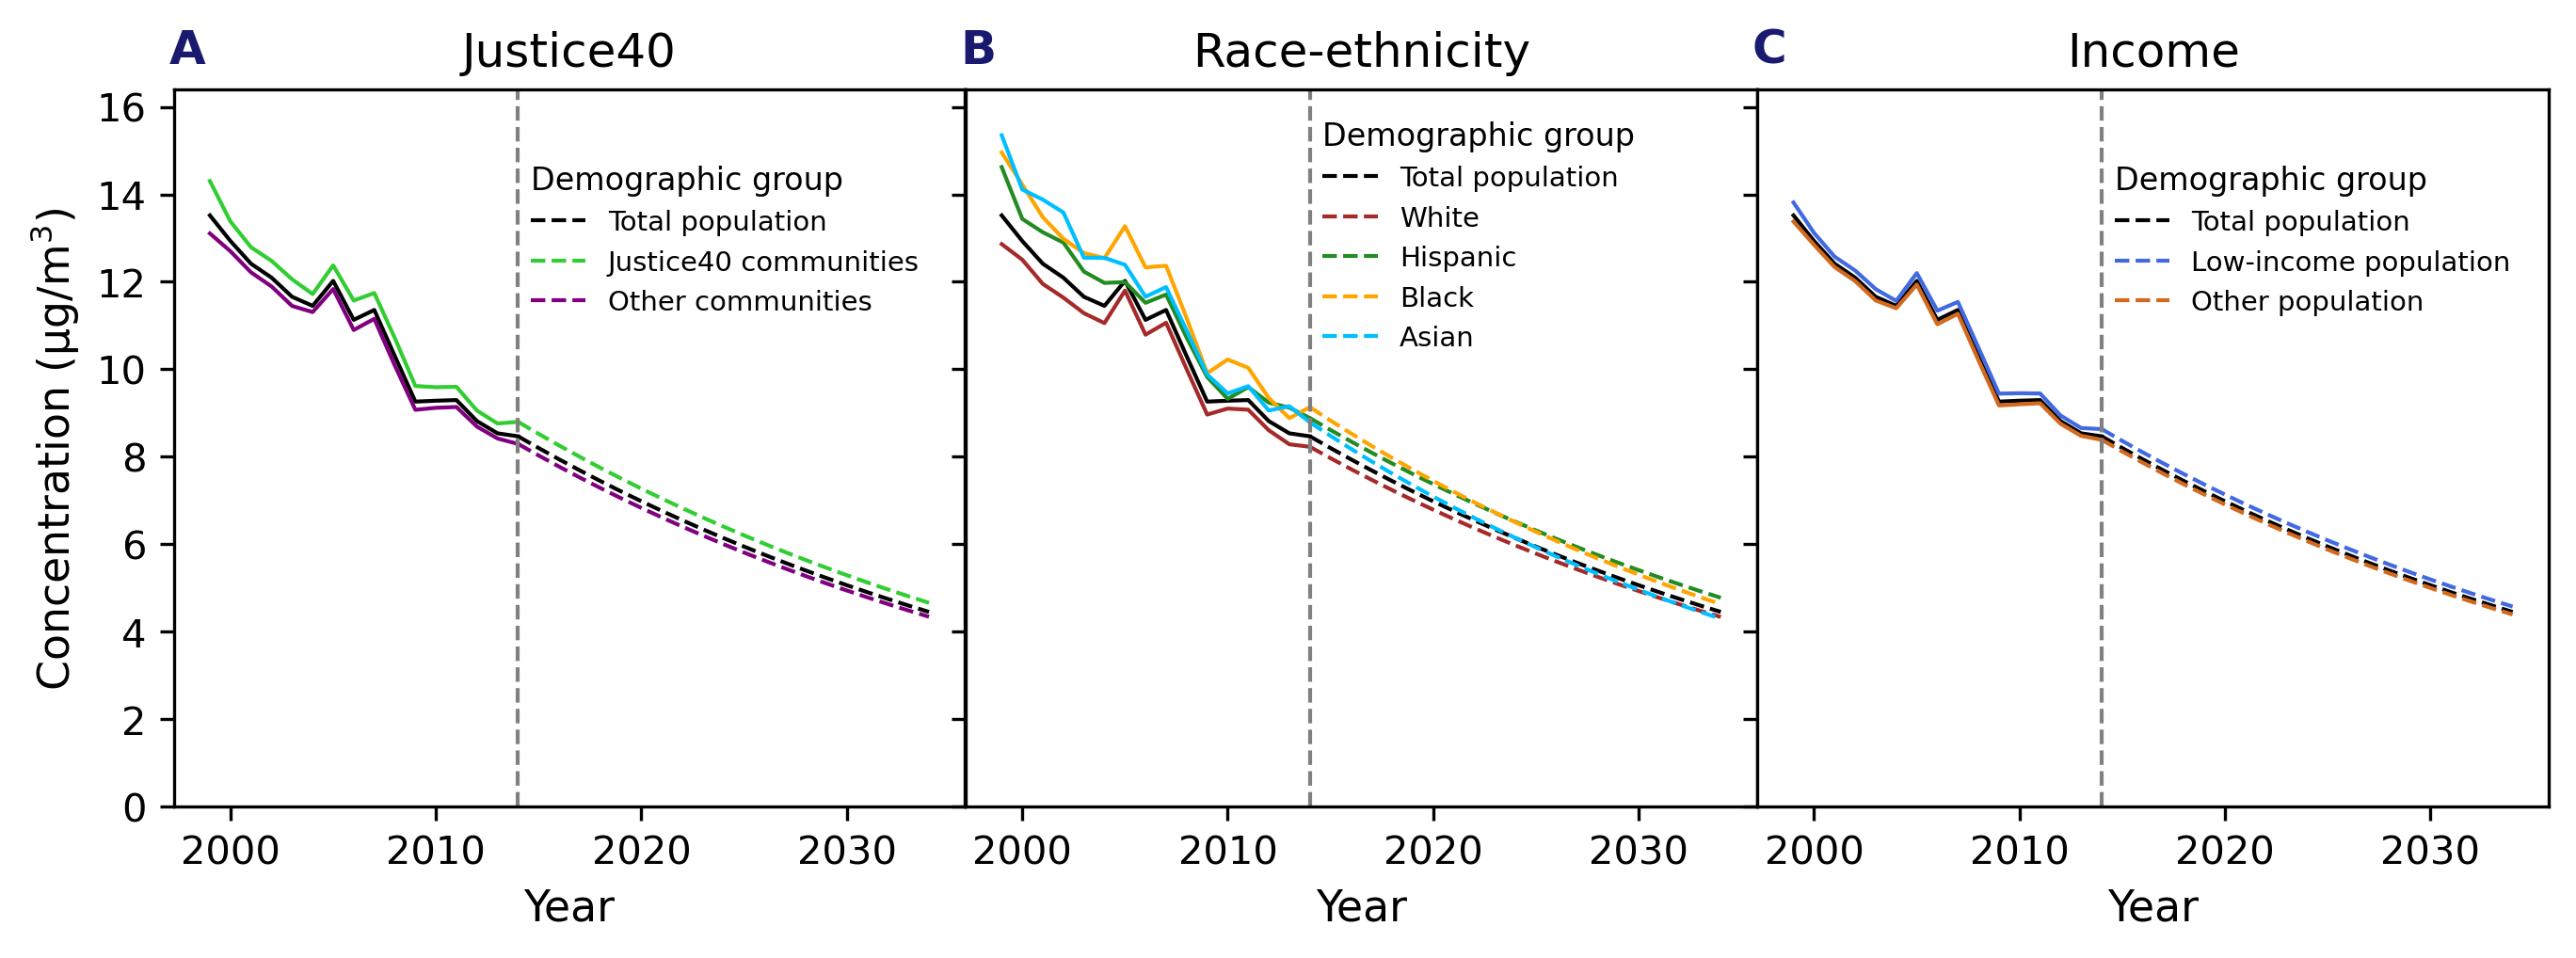

In [18]:
fig, ax = plt.subplots(ncols = 3,figsize = (9.5,3.5),dpi = 300,sharey = True,sharex = True)
ax[0].plot("year", "Population",data = pred_pm25_forecast.iloc[0:16], color="Black",linewidth = 1,label = "")
ax[0].plot("year", "Population",data =pred_relative_pm25_forecast.iloc[15:], color="Black",linestyle = "--",linewidth = 1,label = "Total population")
ax[0].plot("year", "J40",data =pred_pm25_forecast.iloc[0:16], color="limegreen",linewidth = 1,label = "")
ax[0].plot("year", "J40",data =pred_relative_pm25_forecast.iloc[15:], color="limegreen",linestyle = "--",linewidth = 1,label = "Justice40 communities")
ax[0].plot("year", "non_J40",data =pred_pm25_forecast.iloc[0:16], color="purple",linewidth = 1,label = "")
ax[0].plot("year", "non_J40",data =pred_relative_pm25_forecast.iloc[15:], color="purple",linestyle = "--",linewidth = 1,label = "Other communities")

ax[1].plot("year", "Population",data =pred_pm25_forecast.iloc[0:16], color="Black",linewidth = 1,label = "")
ax[1].plot("year", "Population",data =pred_relative_pm25_forecast.iloc[15:], color="Black",linestyle = "--",linewidth = 1,label = "Total population")
ax[1].plot("year", "White",data =pred_pm25_forecast.iloc[0:16], color="brown",linewidth = 1,label = "")
ax[1].plot("year", "White",data =pred_relative_pm25_forecast.iloc[15:], color="brown",linestyle = "--",linewidth = 1,label = "White")
ax[1].plot("year", "Hispanic",data =pred_pm25_forecast.iloc[0:16], color="forestgreen",linewidth = 1,label = "")
ax[1].plot("year", "Hispanic",data =pred_relative_pm25_forecast.iloc[15:], color="forestgreen",linestyle = "--",linewidth = 1,label = "Hispanic")
ax[1].plot("year", "Black",data =pred_pm25_forecast.iloc[0:16], color="orange",linewidth = 1,label = "")
ax[1].plot("year", "Black",data =pred_relative_pm25_forecast.iloc[15:], color="orange",linestyle = "--",linewidth = 1,label = "Black")
ax[1].plot("year", "Asian",data =pred_pm25_forecast.iloc[0:16], color="deepskyblue",linewidth = 1,label = "")
ax[1].plot("year", "Asian",data =pred_relative_pm25_forecast.iloc[15:], color="deepskyblue",linestyle = "--",linewidth = 1,label = "Asian")

ax[2].plot("year", "Population",data = pred_pm25_forecast.iloc[0:16], color="Black",linewidth = 1,label = "")
ax[2].plot("year", "Population",data =pred_relative_pm25_forecast.iloc[15:], color="Black",linestyle = "--",linewidth = 1,label = "Total population")
ax[2].plot("year", "Poverty",data =pred_pm25_forecast.iloc[0:16], color="royalblue",linewidth = 1,label = "")
ax[2].plot("year", "Poverty",data =pred_relative_pm25_forecast.iloc[15:], color="royalblue",linestyle = "--",linewidth = 1,label = "Low-income population")
ax[2].plot("year", "non_Poverty",data =pred_pm25_forecast.iloc[0:16], color="chocolate",linewidth = 1,label = "")
ax[2].plot("year", "non_Poverty",data =pred_relative_pm25_forecast.iloc[15:], color="chocolate",linestyle = "--",linewidth = 1,label = "Other population")
ax[0].set_ylim(0,16.4)


ax[0].set_ylabel('Concentration ('r'$\rm\mu g/m^3)$',size = 11)
ax[0].set_xlabel("Year",size = 11)
ax[1].set_xlabel("Year",size = 11)
ax[2].set_xlabel("Year",size = 11)

legend = ax[0].legend(bbox_to_anchor=(0.42, 0.65), frameon=False,fontsize = 7)
legend.set_title("Demographic group",prop={'size':8})
legend._legend_box.align = "left"

legend = ax[1].legend(bbox_to_anchor=(0.42, 0.6), frameon=False,fontsize = 7)
legend.set_title("Demographic group",prop={'size':8})
legend._legend_box.align = "left"

legend = ax[2].legend(bbox_to_anchor=(0.42, 0.65), frameon=False,prop = {"size":7})
legend.set_title("Demographic group",prop = {"size":8})
legend._legend_box.align = "left"
ax[0].set_title("Justice40")
ax[1].set_title("Race-ethnicity")
ax[2].set_title("Income")
ax[0].text(1997,17, 'A', fontsize = 12,horizontalalignment='left',color = "midnightblue",weight='bold')
ax[1].text(1997,17, 'B', fontsize = 12,horizontalalignment='left',color = "midnightblue",weight='bold')
ax[2].text(1997,17, 'C', fontsize = 12,horizontalalignment='left',color = "midnightblue",weight='bold')

ax[0].axvline(x = 2014,color = "grey",linewidth = 1, linestyle = "--")
ax[1].axvline(x = 2014,color = "grey",linewidth = 1, linestyle = "--")
ax[2].axvline(x = 2014,color = "grey",linewidth = 1, linestyle = "--")

plt.tight_layout(w_pad = -2.1)
plt.show()

ax[0].set_ylim(0,16.4)

plt.show()

In [19]:
pred_relative_pm25_forecast["disparity"] = pred_relative_pm25_forecast[["Black","Asian","Hispanic"]].max(axis = 1)-pred_relative_pm25_forecast["Population"]
pred_relative_pm25_forecast["disparity_poc"] = pred_relative_pm25_forecast["POC"]-pred_relative_pm25_forecast["Population"]
pred_relative_pm25_forecast["disparity_j40"] = pred_relative_pm25_forecast["J40"]-pred_relative_pm25_forecast["Population"]
pred_relative_pm25_forecast["disparity_lowinc"] = pred_relative_pm25_forecast["Poverty"]-pred_relative_pm25_forecast["Population"]


In [20]:
pred_relative_pm25_forecast["rel_disparity"] = pred_relative_pm25_forecast["disparity"]/pred_relative_pm25_forecast["Population"]*100
pred_relative_pm25_forecast["rel_disparity_poc"] = pred_relative_pm25_forecast["disparity_poc"]/pred_relative_pm25_forecast["Population"]*100
pred_relative_pm25_forecast["rel_disparity_j40"] = pred_relative_pm25_forecast["disparity_j40"]/pred_relative_pm25_forecast["Population"]*100
pred_relative_pm25_forecast["rel_disparity_lowinc"] = pred_relative_pm25_forecast["disparity_lowinc"]/pred_relative_pm25_forecast["Population"]*100


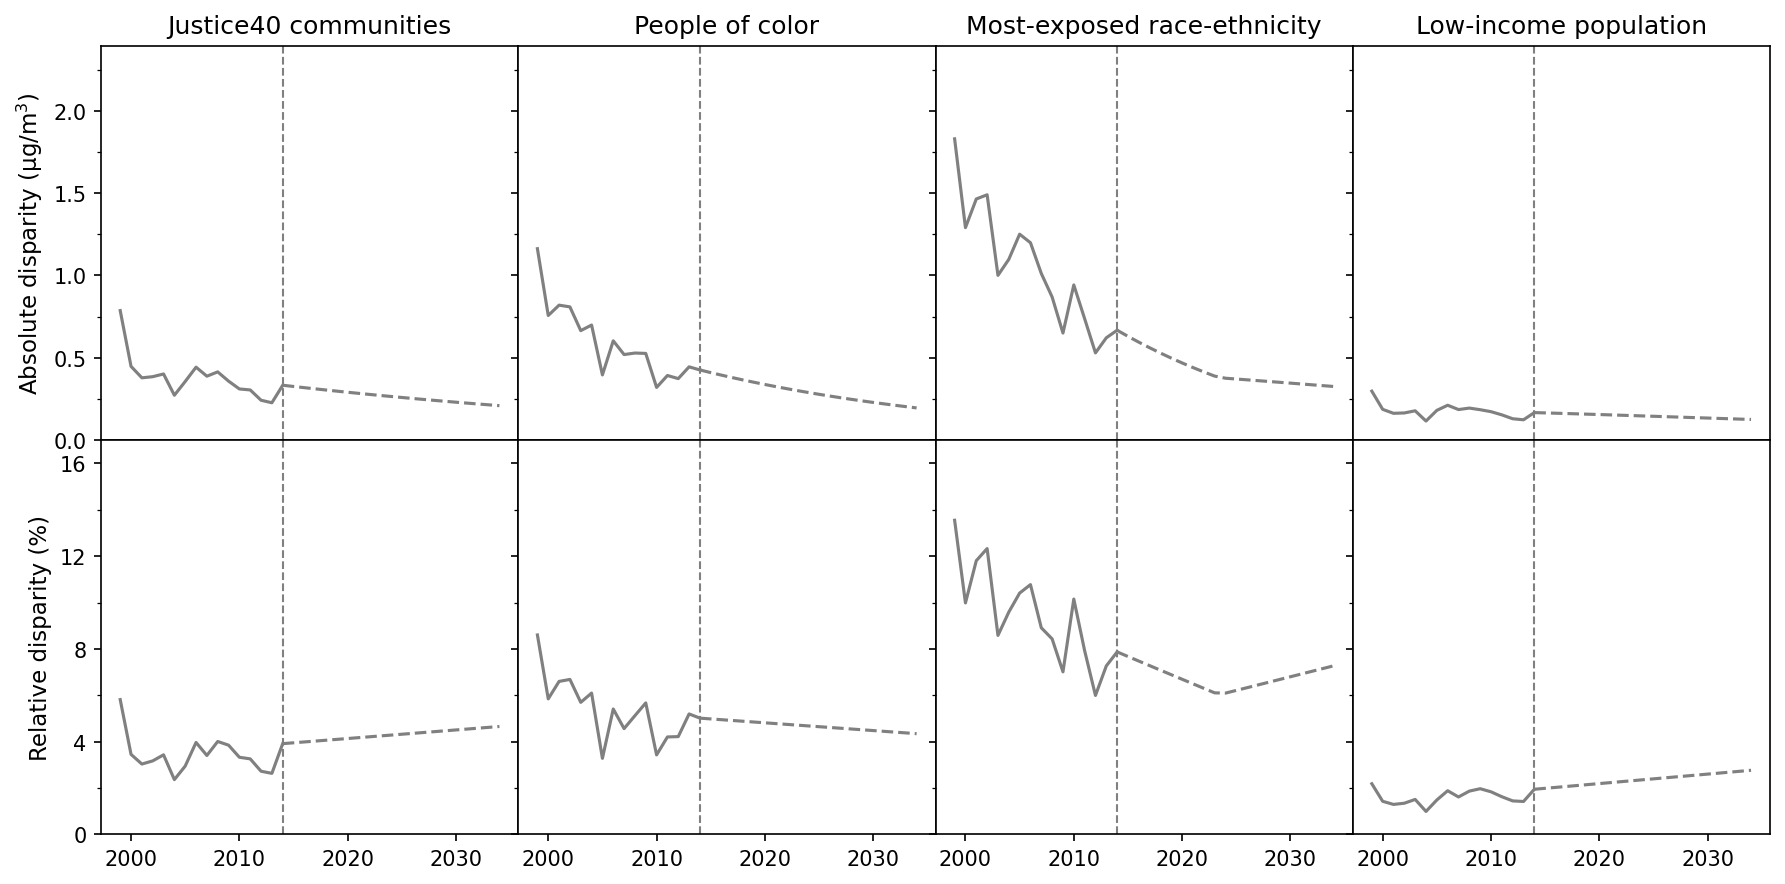

In [21]:
fig, ax = plt.subplots(ncols = 4, nrows = 2, figsize = (12,6),dpi = 150,sharey = "row",sharex = True)
ax[0,0].plot("year", "disparity_j40",data = pred_relative_pm25_forecast.iloc[0:16], color="grey",linewidth = 1.5,label = "")
ax[0,0].plot("year", "disparity_j40",data =pred_relative_pm25_forecast.iloc[15:], color="grey",linestyle = "--",linewidth = 1.5,label = "Total population")
ax[0,0].set_ylim(0,2.4)

ax[0,1].plot("year", "disparity_poc",data = pred_relative_pm25_forecast.iloc[0:16], color="grey",linewidth = 1.5,label = "")
ax[0,1].plot("year", "disparity_poc",data =pred_relative_pm25_forecast.iloc[15:], color="grey",linestyle = "--",linewidth = 1.5,label = "Total population")

ax[0,2].plot("year", "disparity",data = pred_relative_pm25_forecast.iloc[0:16], color="grey",linewidth = 1.5,label = "")
ax[0,2].plot("year", "disparity",data =pred_relative_pm25_forecast.iloc[15:], color="grey",linestyle = "--",linewidth = 1.5,label = "Total population")


ax[0,3].plot("year", "disparity_lowinc",data = pred_relative_pm25_forecast.iloc[0:16], color="grey",linewidth = 1.5,label = "")
ax[0,3].plot("year", "disparity_lowinc",data =pred_relative_pm25_forecast.iloc[15:], color="grey",linestyle = "--",linewidth = 1.5,label = "Total population")

ax[0,0].axvline(x = 2014,color = "grey",linewidth = 1, linestyle = "--")
ax[0,1].axvline(x = 2014,color = "grey",linewidth = 1, linestyle = "--")
ax[0,2].axvline(x = 2014,color = "grey",linewidth = 1, linestyle = "--")
ax[0,3].axvline(x = 2014,color = "grey",linewidth = 1, linestyle = "--")


ax[1,0].plot("year", "rel_disparity_j40",data = pred_relative_pm25_forecast.iloc[0:16], color="grey",linewidth = 1.5,label = "")
ax[1,0].plot("year", "rel_disparity_j40",data =pred_relative_pm25_forecast.iloc[15:], color="grey",linestyle = "--",linewidth = 1.5,label = "Total Population")
ax[1,0].set_ylim(0,17)

ax[1,1].plot("year", "rel_disparity_poc",data = pred_relative_pm25_forecast.iloc[0:16], color="grey",linewidth = 1.5,label = "")
ax[1,1].plot("year", "rel_disparity_poc",data =pred_relative_pm25_forecast.iloc[15:], color="grey",linestyle = "--",linewidth = 1.5,label = "Total Population")

ax[1,2].plot("year", "rel_disparity",data = pred_relative_pm25_forecast.iloc[0:16], color="grey",linewidth = 1.5,label = "")
ax[1,2].plot("year", "rel_disparity",data =pred_relative_pm25_forecast.iloc[15:], color="grey",linestyle = "--",linewidth = 1.5,label = "Total Population")

ax[1,3].plot("year", "rel_disparity_lowinc",data = pred_relative_pm25_forecast.iloc[0:16], color="grey",linewidth = 1.5,label = "")
ax[1,3].plot("year", "rel_disparity_lowinc",data =pred_relative_pm25_forecast.iloc[15:], color="grey",linestyle = "--",linewidth = 1.5,label = "Total Population")

ax[1,0].axvline(x = 2014,color = "grey",linewidth = 1, linestyle = "--")
ax[1,1].axvline(x = 2014,color = "grey",linewidth = 1, linestyle = "--")
ax[1,2].axvline(x = 2014,color = "grey",linewidth = 1, linestyle = "--")
ax[1,3].axvline(x = 2014,color = "grey",linewidth = 1, linestyle = "--")

ax[0,0].set_title("Justice40 communities")
ax[0,1].set_title("People of color")
ax[0,2].set_title("Most-exposed race-ethnicity")
ax[0,3].set_title("Low-income population")

ax[0,0].set_ylabel(r'Absolute disparity ('r'$\rm\mu g/m^3)$',size = 11)
ax[1,0].set_ylabel('Relative disparity (%)',size = 11)
ax[0,0].set_yticks([0,0.5,1,1.5,2])
ax[0,0].set_yticks([0.25,0.75,1.25,1.75,2.25],minor = True)
ax[1,0].set_yticks([0,4,8,12,16])
ax[1,0].set_yticks([2,6,10,14],minor = True)

plt.tight_layout(w_pad = -1.6, h_pad = -0.55)

plt.show()